### 목표
- 네이버 영화 리뷰의 긍정, 부정을 예측하는 순환 신경망 모델을 만들어보자 !
- 학습용 데이터가 아닌 실제 리뷰(텍스트) 데이터를 전처리해서 신경망에 넣어보자 !

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 42.9 MB/s eta 0:00:00


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정

/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정


In [4]:
df_train = pd.read_csv('data/ratings_train.txt', delimiter = '\t')
df_test = pd.read_csv('data/ratings_test.txt', delimiter = '\t')

In [5]:
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [8]:
# 결측치가 존재하는 행 제거
df_train.dropna(inplace = True)
df_test.dropna(inplace = True)

- 문제, 정답 데이터로 분리

In [9]:
# id 컬럼은 분석에 큰 영향이 없을 것 같으니 제외
X_train = df_train['document']
y_train = df_train['label']
X_test = df_test['document']
y_test = df_test['label']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(149995,)
(49997,)
(149995,)
(49997,)


### konlpy의 형태소 분석기(문장을 형태소로 분리해주는 도구)종류
- kkma : 서울대학교 데이터 랩에서 개발, 일반적인 성능은 좋으나 분석시간이 konlpy 형태소 분석기 중 가장 오래걸림
- Okt : twitter에서 개발, twitter 데이터를 기반으로 형태소를 추출하기때문에 인터넷 텍스트에 특화되어있고, 비표준어, 비속어 등이 포함되어있는 정제되지 않은 데이터처리에 강함 + 추가로 konlpy 형태소 분석기 중 유일하게 stemming(어간추출)기능을 포함하고 있음. 속도는 준수하나 동음이의어 처리가 어렵고, 분석 범주가 다른 형태소 분석기에 비해 좁은 단점을 가짐.
- komoran : Shineware에서 개발, 오탈자에 대해 분석 품질은 좋으나 띄어쓰기가 없는 문장을 분석하는데 좋지 않음
- Hannanum : KAIST에서 개발, 띄어쓰기가 없는 문장에서 분석 품질이 좋지 않음
- Mecab : 일본어용 형태소 분석기를 한국어에 사용할 수 있도록 수정한 분석기, 속도가 5개 중 가장 빠르나 window에서 설치가 힘들고 동음이의어 처리에 취약함.


#### 위 다섯 개 형태소 분석기 모두 nonus, morphs, pos 함수를 지원
- nonus : 주어진 문장의 명사를 추출
- morphs : 주어진 문장의 형태소를 추출
- pos : 주어진 문장의 형태소와 각 단어의 품사를 식별하여 태그를 추가해 함께 출력(품사 태깅)

In [10]:
# 인터넷 영화 리뷰를 분석하는데 적합한 Okt 형태소 분석기 임포트
from konlpy.tag import Okt
from tqdm import tqdm
import pickle

In [11]:
okt = Okt()

In [12]:
# 형태소 추출 후 공백을 주면서 각각의 문장으로 연결(뒤에 이어질 토큰화에서 공백 기준으로 토큰화시켜주기 위함)
# 긴 문장이나 띄어쓰기가 잘 되어있지 않은 경우 토큰화의 성능이 좋지 않기 때문에 문장을 형태소로 분리한 후 공백을 줘서 다시 문장으로 재구성함 !
X_train_morphs = [' '.join(okt.morphs(doc)) for doc in tqdm(X_train)]
X_test_morphs = [' '.join(okt.morphs(doc)) for doc in tqdm(X_test)]

100%|██████████| 49997/49997 [01:31<00:00, 544.10it/s]


In [ ]:
X_train_morphs

In [14]:
# pickle 파일로 저장(colab 재접속시 바로 가공된 데이터를 사용하기 위함)
# pickle : 텍스트 파일이 아닌 데이터의 자료 구조 형태를 그대로 저장하거나 불러오는 모듈
with open('data/X_train_morphs.pkl', 'wb') as f :
  pickle.dump(X_train_morphs, f)

with open('data/X_test_morphs.pkl', 'wb') as f :
  pickle.dump(X_test_morphs, f)

In [15]:
# pickle 파일 로드(형태소로 분리되어 문장화 되어있는 상태 그대로 로드)
with open('data/X_train_morphs.pkl', 'rb') as f :
  X_train = pickle.load(f)

with open('data/X_test_morphs.pkl', 'rb') as f :
  X_test = pickle.load(f)

### keras에서 지원하는 한글을 포함하는 토크나이저(Tokenizer)를 사용해서 토큰화 시켜보자 !

- keras 지원 Tokenizer 특징
- 1) 공백(띄어쓰기) 기준으로 토큰화
- 2) 빈도수 기준으로 자동 레이블 인코딩(로이터 뉴스 데이터 처럼 !)
- 3) 기본적인 한국어 정규표현식이 적용

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [17]:
tokenizer = Tokenizer()

In [18]:
# 토크나이저로 핛브 후 단어사전(BoW) 생성
tokenizer.fit_on_texts(X_train)

In [ ]:
# 각 토큰들의 빈도수에 따른 인코딩 결과(랭킹) 출력
tokenizer.word_index

# '이' 라는 토큰이 가장 많이 사용되었으며 1로 인코딩 됨

In [ ]:
# 각 토큰이 얼마나 사용되었는지 빈도수 출력
tokenizer.word_counts

In [21]:
# BoW에 있는 전체 토큰 개수
len(tokenizer.word_index)

102054

### 빈도가 너무 낮은 토큰들을 제거해보자
- 정렬을 이용해서 단어의 빈도수를 확인하고 순위까지 보자 !

In [ ]:
tokenizer.word_counts.items()

In [23]:
df = pd.DataFrame(tokenizer.word_counts.items(),
                  columns = ['Token', 'Count']
                  )

df.head()

,Token,Count
0,아,4373
1,더빙,573
2,진짜,8343
3,짜증나네요,22
4,목소리,375


In [24]:
# 정렬 후 출력되는 index는 의미가 없으므로 reset_index로 현재 values 상태 그대로 다시 인덱스를 매겨줌
# drop = True : 기존 index를 컬럼에서 없애줌
df_sorted = df.sort_values(by = 'Count', ascending = False).reset_index(drop = True)
df_sorted

,Token,Count
0,이,56108
1,영화,50737
2,의,30963
3,가,27571
4,에,26772
...,...,...
102049,매조키즘,1
102050,나온거라니,1
102051,맡아던,1
102052,어케해,1


In [25]:
# 등장 빈도가 20번 미만인 데이터를 제거하자(최서 20번은 나와야 BoW에 저장하기 !)
df_sorted[df_sorted['Count'] < 20]

,Token,Count
7852,지루하다는,19
7853,상관없이,19
7854,소라,19
7855,아따,19
7856,살아라,19
...,...,...
102049,매조키즘,1
102050,나온거라니,1
102051,맡아던,1
102052,어케해,1


In [26]:
# num_words : 원하는 인덱스 번호까지만 사용(학습 데이터에서 빈도수가 높은 7851개의 데이터만 사용하겠다는 뜻)
final_tokenizer = Tokenizer(num_words = 7851)

In [27]:
final_tokenizer.fit_on_texts(X_train)

In [28]:
# texts_to_sequences : 토큰들을 인코딩 시킨 결과를 순서대로 리스트에 넣어줌
X_train_seq = final_tokenizer.texts_to_sequences(X_train)
X_test_seq = final_tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train_seq

# 다만 빈도수가 20회 미만인 데이터는 사용하지 않았기 때문에 단어가 부족한 리스트가 있을 수 있음.

- 현재까지가 raw 데이터(리뷰 데이터)에서
- 1) 형태소 추출, 2) 토큰화 + 랭킹 순 인코딩, 3) 빈도수가 적은 단어 제외까지 진행한 상태
- 한국어 같은 경우는 형태소 추출이나 토큰화 단계에서 조사나 접속사를 제거하면 되기때문에 따로 정해진 불용어가 없음(직접 설정하고 싶다면 불용어 사전을 만들고 기존 데이터에서 not in으로 제거해주면 됨)

### 순환 신경망에 넣기 위해 리뷰 데이터의 시퀀스 길이를 알아보자 !

In [30]:
# X_train_seq에 있는 내부 리스트의 개수(시퀀스 길이)를 반환하여 리스트에 저장
X_train_len = [len(doc) for doc in X_train_seq]

In [ ]:
X_train_len

In [32]:
print("최대값 :", max(X_train_len))
print("최소값 :", min(X_train_len))
print("평균값 :", np.mean(X_train_len))
print("중앙값 :", np.median(X_train_len))

# 길이가 0개인 리뷰는 빈도수가 20회 미만인 단어들로만 이루어져 있어서 전부 없어짐

최대값 : 77
최소값 : 0
평균값 : 11.362445414847162
중앙값 : 9.0


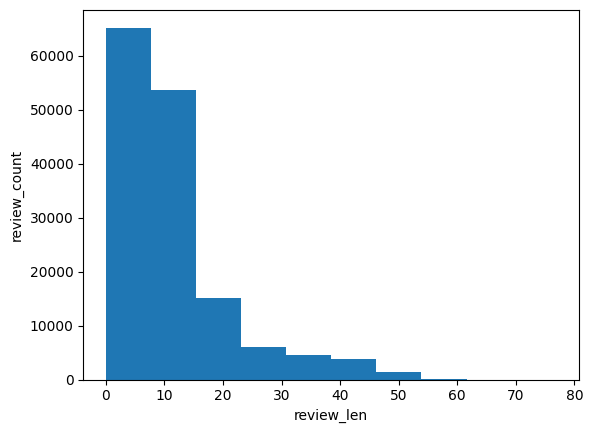

In [33]:
# 히스토그램으로 리뷰 길이의 분포를 확인해보자 !
plt.hist(X_train_len, bins = 10)
plt.xlabel('review_len')
plt.ylabel('review_count')
plt.show()

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad_seq = pad_sequences(X_train_seq, maxlen = 15)
X_test_pad_seq = pad_sequences(X_test_seq, maxlen = 15)

In [35]:
X_train_pad_seq.shape, X_test_pad_seq.shape

((149995, 15), (49997, 15))

In [36]:
X_train_pad_seq[62]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  180,    5,
       1309, 1295,  315,  910], dtype=int32)

### 신경망 모델링
- 입력층에 임베딩 층 설정(input_dim 설정)
- 중간층에 LSTM층 설정
- 출력층에 MLP층 설정
- loss, optimizer 고려
- validation 데이터 분리해서 학습
- modelcheckpoint(모델체크포인트), earlystopping(얼리스탑핑)
- 학습 결과 시각화
- test 데이터로 classification_report 출력

In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
review_model = Sequential()

review_model.add(Embedding(input_dim=7851, output_dim=50))
# 학습시 과대적합을 방지하기 위해 매 epoch마다 랜덤하게 30%의 뉴런들의 학습을 비활성화 시킴
review_model.add(Dropout(0.3))

review_model.add(LSTM(128, return_sequences=True))
review_model.add(LSTM(64))

review_model.add(Dense(1, activation='sigmoid'))

review_model.compile(loss='binary_crossentropy',
                     optimizer='Adam',
                     metrics=['acc']
                     )


save_path = save_path = '/content/drive/MyDrive/Colab Notebooks/SW캠프 데이터 비즈니스 과정/data/review_model_{epoch:03d}_{val_acc:.4f}.hdf5'

mckp = ModelCheckpoint(filepath = save_path,
                       monitor='val_acc',
                       save_best_only=True,
                       mode='max',
                       verbose=1
                       )

early = EarlyStopping(monitor='val_acc',
                      patience=5
                      )

h = review_model.fit(X_train_pad_seq, y_train,
                     validation_split=0.2,
                     batch_size=128,
                     epochs=100,
                     callbacks=[mckp, early]
                     )

KeyboardInterrupt: ignored

In [ ]:
review_model.evaluate(X_test_pad_seq, y_test)

In [ ]:
y_test

In [ ]:
# 이진 분류에서는 출력층 뉴런수가 1개이므로 0~1사이 확률값이 하나만 나오는데 이를 0 or 1로 변환시켜줘야함
# pre 내부 값이 0.5보다 크면 True 출력, 아니면 False가 출력되는데(파이썬에서는 True가 1, False가 0으로 인식) 이를 정수로 변환
pre_binary = (pre > 0.5).astype(int)
pre_binary

In [ ]:
from sklearn.metrics import classification_report
# 예측값을 변화시킨 결과가 0또는 1이기때문에 argmax를 사용할 필요 없음
print(classification_report(y_test, pre_binary))